# Import required packages

In [302]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Convolution1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import seaborn as sns
# Word2vec
import gensim

# Utility
import ssl
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [303]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santhosh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [304]:
# DATASET
DATASET_COLUMNS = ["message", "label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [305]:
df = pd.read_csv('d1.csv')
print(df.iloc[:10])

   Unnamed: 0                                            message  label
0           0  The lack of this understanding is a small but ...      1
1           1  i just told my parents about my depression and...      1
2           2  depression is something i don't speak about ev...      1
3           3  Made myself a tortilla filled with pb&j. My de...      1
4           4  @WorldofOutlaws I am gonna need depression med...      1
5           5  my anxiety and my depression fighting over who...      1
6           6  wow she's suddenly cured my depression and gav...      1
7           7  I am officially done with @kanyewest. him, the...      1
8           8  Me: what's wrong?My girl: *looks up at me with...      1
9           9  @AusBorderForce @PeterDutton_MP @shanebazzi Ag...      1


**Preprocessing**

In [306]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [307]:
def preprocess(text, stem=True):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [308]:
print(preprocess("buses", stem = False))

buses


In [309]:
print(df.head())
df.message = df.message.apply(lambda x: preprocess(x))

print("after preprocessing")
print(df.head())


   Unnamed: 0                                            message  label
0           0  The lack of this understanding is a small but ...      1
1           1  i just told my parents about my depression and...      1
2           2  depression is something i don't speak about ev...      1
3           3  Made myself a tortilla filled with pb&j. My de...      1
4           4  @WorldofOutlaws I am gonna need depression med...      1
after preprocessing
   Unnamed: 0                                            message  label
0           0  lack understand small signific part caus anxie...      1
1           1  told parent depress hard get gen x peopl under...      1
2           2  depress someth speak even go also doubl edg sw...      1
3           3  made tortilla fill pb j depress cure olivia 1 ...      1
4           4  gonna need depress med soon rainout spin equil...      1


In [310]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 6524
TEST size: 1631


In [311]:
documents = [_message.split() for _message in df_train.message]
print(documents[:10])

[['hide', 'depress', 'success'], ['way', 'marbella', 'spain', 'see', 'u', 'guy', 'later'], ['close', 'refurbish', 'sunday', 'definit', 'worth', 'visit', 'cambridg', 'weekend'], ['yeah', 'right'], ['normal', 'feel', 'like', 'postpartum', 'depress', 'jst', 'emosh', 'emoji', 'slight', 'frown', 'face', 'emoji', 'disappoint', 'reliev', 'face', 'feel', 'worri'], ['kilwa', 'potteri', 'sherd', 'one', 'best', 'bbc', 'britishmuseum', 'historyoftheworldin100object', 'episod'], ['journey2worthi', 'podcast', 'episod', '13flat', 'fit', 'listen', 'lasagafit', 'explian', 'overcam', 'sever', 'depress', 'start', 'fit', 'compani', 'tune', 'pic', 'twitter', 'com', 'saxildoibq'], ['stereotyp', 'think', 'complet', 'live', 'um', 'probabl', 'millenni', 'lazi', 'entitl', 'etc', 'total', 'oh', 'whole', 'depress'], ['eek', 'need', 'put', 'date', 'diari', 'amp', 'get', 'nationalgalleri', 'love', 'soundscap', 'art', 'music', 'life'], ['u', 'spend', 'ur', 'whole', 'life', 'think', 'deal', 'thing', 'way', 'u', 'deem

In [312]:
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [315]:
w2v_model.build_vocab(documents)

In [316]:
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1166


In [317]:

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
print(documents[0]);

['hide', 'depress', 'success']


In [327]:
w2v_model.wv.most_similar("hate")

[('turn', 0.7014253735542297),
 ('carri', 0.6596567034721375),
 ('weight', 0.6484444737434387),
 ('wors', 0.6143853068351746),
 ('honest', 0.6102281212806702),
 ('empti', 0.5964606404304504),
 ('push', 0.5853158235549927),
 ('lose', 0.564375638961792),
 ('smoke', 0.562004804611206),
 ('shit', 0.5583406090736389)]

In [328]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.message)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 9570


In [329]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.message), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.message), maxlen=SEQUENCE_LENGTH)

In [330]:
x_train[0:10]

array([[   0,    0,    0, ..., 1070,    1, 1268],
       [   0,    0,    0, ...,   34,  273,  424],
       [   0,    0,    0, ...,  111,  452,  224],
       ...,
       [   0,    0,    0, ...,  135,  437,    1],
       [   0,    0,    0, ...,  115,  163,   26],
       [   0,    0,    0, ...,    2,  694,  797]], dtype=int32)

In [331]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (6524, 1)
y_test (1631, 1)


In [332]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6524, 300)
y_train (6524, 1)

x_test (1631, 300)
y_test (1631, 1)


In [333]:
y_train[50:70]

array([[1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [334]:
print(tokenizer.word_index.items())

dict_items([('depress', 1), ('anxieti', 2), ('emoji', 3), ('twitter', 4), ('like', 5), ('pic', 6), ('com', 7), ('go', 8), ('day', 9), ('get', 10), ('love', 11), ('face', 12), ('good', 13), ('one', 14), ('feel', 15), ('know', 16), ('thank', 17), ('britishmuseum', 18), ('peopl', 19), ('time', 20), ('great', 21), ('help', 22), ('see', 23), ('work', 24), ('today', 25), ('life', 26), ('make', 27), ('think', 28), ('look', 29), ('realli', 30), ('thing', 31), ('mental', 32), ('want', 33), ('u', 34), ('much', 35), ('well', 36), ('take', 37), ('new', 38), ('back', 39), ('got', 40), ('happi', 41), ('need', 42), ('year', 43), ('amp', 44), ('tri', 45), ('health', 46), ('use', 47), ('would', 48), ('come', 49), ('someon', 50), ('talk', 51), ('never', 52), ('way', 53), ('say', 54), ('suicid', 55), ('2', 56), ('nationalgalleri', 57), ('right', 58), ('us', 59), ('cure', 60), ('heart', 61), ('even', 62), ('friend', 63), ('could', 64), ('lol', 65), ('caus', 66), ('suffer', 67), ('night', 68), ('live', 69)

In [335]:
w2v_model.wv['depress']

array([-1.92024648e-01, -2.77189612e-01, -1.59575492e-02, -7.88112730e-03,
       -2.28034481e-01,  1.10867940e-01,  1.22339331e-01,  2.47601584e-01,
        4.82572988e-02, -1.23012312e-01,  4.29660499e-01,  3.13828021e-01,
       -2.89963186e-01, -5.87191507e-02,  3.52591217e-01,  1.20268442e-01,
        3.92885834e-01, -6.37762964e-01,  5.41273679e-04,  3.58330488e-01,
       -3.66761029e-01, -2.01038182e-01,  7.75740743e-01,  1.02419622e-01,
        2.08836541e-01,  2.76683688e-01, -7.68548995e-02, -2.36948565e-01,
       -2.98869908e-01, -2.73561001e-01, -7.38072753e-01,  1.34221941e-01,
       -2.10800126e-01, -1.25358999e-01,  1.61235586e-01,  2.64839828e-01,
        9.63775888e-02,  2.02973709e-01, -3.16191576e-02,  4.42249328e-01,
        5.08158021e-02,  2.05217361e-01,  8.85749143e-03, -1.48072124e-01,
        4.47312683e-01,  1.38365149e-01, -1.38029028e-02, -5.43893129e-02,
       -2.31594518e-01,  7.04963654e-02,  4.29946452e-01,  1.25470161e-01,
       -6.45504713e-01, -

In [336]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(9570, 300)


In [337]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**LSTM Model**

In [338]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 300)          2871000   
                                                                 
 lstm_11 (LSTM)              (None, 128)               219648    
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,090,777
Trainable params: 219,777
Non-trainable params: 2,871,000
_________________________________________________________________


In [340]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [341]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [342]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
6/6 [==============================] - 27s 4s/step - loss: 0.5121 - accuracy: 0.8002 - val_loss: 0.3292 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 2/8
6/6 [==============================] - 25s 4s/step - loss: 0.2543 - accuracy: 0.9070 - val_loss: 0.1859 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 3/8
6/6 [==============================] - 24s 4s/step - loss: 0.1514 - accuracy: 0.9455 - val_loss: 0.1608 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 4/8
6/6 [==============================] - 25s 4s/step - loss: 0.1125 - accuracy: 0.9659 - val_loss: 0.1110 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 5/8
6/6 [==============================] - 25s 4s/step - loss: 0.0745 - accuracy: 0.9770 - val_loss: 0.0782 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 6/8
6/6 [==============================] - 25s 4s/step - loss: 0.0554 - accuracy: 0.9848 - val_loss: 0.0562 - val_accuracy: 0.9847 - lr: 0.0010
Epoch 7/8
6/6 [==============================] - 25s 4s/step - loss: 0.0424 - accuracy: 0.9879 - val

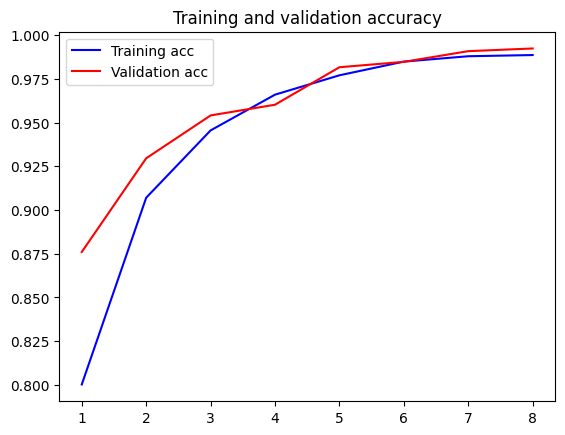

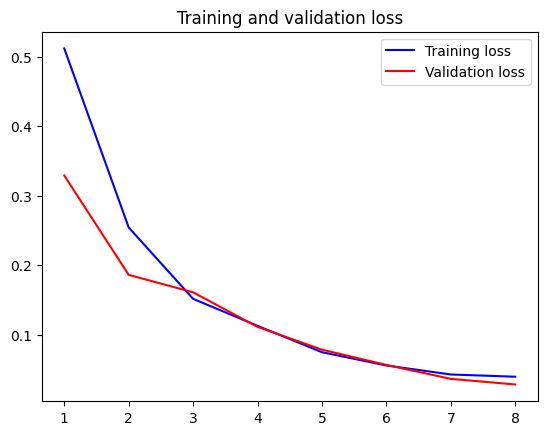

In [343]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [344]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(score)
print("LSTM\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 2s 815ms/step - loss: 0.0308 - accuracy: 0.9920
[0.030802525579929352, 0.9920294284820557]
LSTM
ACCURACY: 0.9920294284820557
LOSS: 0.030802525579929352


In [373]:
labels_pred = model.predict(x_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(y_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

51/51 [==============================] - 11s 201ms/step
Accuracy: 89.64%


In [374]:
report = classification_report(y_test, labels_pred, output_dict=True)
print(report)

{'0': {'precision': 0.8275862068965517, 'recall': 0.9501466275659824, 'f1-score': 0.884641638225256, 'support': 682}, '1': {'precision': 0.9599056603773585, 'recall': 0.8577449947312961, 'f1-score': 0.9059543683917641, 'support': 949}, 'accuracy': 0.8963825873697119, 'macro avg': {'precision': 0.8937459336369551, 'recall': 0.9039458111486393, 'f1-score': 0.8952980033085101, 'support': 1631}, 'weighted avg': {'precision': 0.9045764958930482, 'recall': 0.8963825873697119, 'f1-score': 0.8970424849009251, 'support': 1631}}


In [375]:
data = [['precision', report['1']['precision']], ['recall', report['1']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['1']['f1-score']]]
df_lstm = pd.DataFrame(data, columns=['cat', 'val'])
df_lstm['source'] = 'lstm'
df_lstm.head()

,cat,val,source
0,precision,0.959906,lstm
1,recall,0.857745,lstm
2,accuracy,0.896383,lstm
3,f1-score,0.905954,lstm


,cat,val,source
0,precision,0.988066,lstm
1,recall,0.987738,lstm
2,accuracy,0.987738,lstm
3,f1-score,0.987752,lstm
0,precision,0.870000,hybrid
1,recall,0.940000,hybrid
2,accuracy,0.760000,hybrid
3,f1-score,0.990000,hybrid


In [347]:
def decode_sentiment(score):
    return NEGATIVE if score < 0.5 else POSITIVE

In [348]:
def predict(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    text = " ".join(tokens)
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict(x_test)[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [349]:
predict("i hate my life, suicide is the only option")

1/1 [==============================] - 0s 48ms/step


{'label': 'POSITIVE',
 'score': 0.9251490235328674,
 'elapsed_time': 0.07922792434692383}

In [350]:
predict("I love and enjoy music")

1/1 [==============================] - 0s 49ms/step


{'label': 'NEGATIVE',
 'score': 0.0015907048946246505,
 'elapsed_time': 0.0799708366394043}

**CNN**

In [351]:
model = Sequential()
model.add(embedding_layer)
model.add(Convolution1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [352]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 300)          2871000   
                                                                 
 conv1d_5 (Conv1D)           (None, 298, 32)           28832     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 147, 64)           6208      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 71, 64)          

In [353]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,epochs=12,
                    validation_split=0.1,verbose=1,callbacks=callbacks)

Epoch 1/12
6/6 [==============================] - 5s 685ms/step - loss: 0.6636 - accuracy: 0.5784 - val_loss: 0.6132 - val_accuracy: 0.5911 - lr: 0.0010
Epoch 2/12
6/6 [==============================] - 4s 628ms/step - loss: 0.5737 - accuracy: 0.6544 - val_loss: 0.5317 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 3/12
6/6 [==============================] - 4s 624ms/step - loss: 0.5130 - accuracy: 0.7210 - val_loss: 0.4930 - val_accuracy: 0.7335 - lr: 0.0010
Epoch 4/12
6/6 [==============================] - 4s 629ms/step - loss: 0.4766 - accuracy: 0.7522 - val_loss: 0.4504 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 5/12
6/6 [==============================] - 4s 648ms/step - loss: 0.4459 - accuracy: 0.7622 - val_loss: 0.4300 - val_accuracy: 0.7626 - lr: 0.0010
Epoch 6/12
6/6 [==============================] - 4s 643ms/step - loss: 0.4273 - accuracy: 0.7706 - val_loss: 0.4219 - val_accuracy: 0.7657 - lr: 0.0010
Epoch 7/12
6/6 [==============================] - 4s 741ms/step - loss: 0.4128 - a

In [354]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("CNN\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 1s 268ms/step - loss: 0.4192 - accuracy: 0.7621

CNN
ACCURACY: 0.7621091604232788
LOSS: 0.41915690898895264


In [355]:
labels_pred = model.predict(x_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(y_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

51/51 [==============================] - 1s 12ms/step
Accuracy: 76.21%


In [356]:
report = classification_report(y_test, labels_pred, output_dict=True)
report

{'0': {'precision': 0.6506147540983607,
  'recall': 0.9310850439882697,
  'f1-score': 0.7659831121833534,
  'support': 682},
 '1': {'precision': 0.9282442748091603,
  'recall': 0.6406743940990516,
  'f1-score': 0.7581047381546134,
  'support': 949},
 'accuracy': 0.7621091354996934,
 'macro avg': {'precision': 0.7894295144537604,
  'recall': 0.7858797190436606,
  'f1-score': 0.7620439251689834,
  'support': 1631},
 'weighted avg': {'precision': 0.812153941808078,
  'recall': 0.7621091354996934,
  'f1-score': 0.7613990674541847,
  'support': 1631}}

In [357]:
data = [['precision', report['1']['precision']], ['recall', report['1']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['1']['f1-score']]]
df_cnn = pd.DataFrame(data, columns=['cat', 'val'])
df_cnn['source'] = 'cnn'
df_cnn.head()

,cat,val,source
0,precision,0.928244,cnn
1,recall,0.640674,cnn
2,accuracy,0.762109,cnn
3,f1-score,0.758105,cnn


**LSTM+CNN**

In [367]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))

model.add(Convolution1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [368]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 300)          2871000   
                                                                 
 lstm_13 (LSTM)              (None, 300, 128)          219648    
                                                                 
 conv1d_10 (Conv1D)          (None, 298, 32)           12320     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 149, 32)          0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 149, 32)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 147, 64)           6208      
                                                     

In [369]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_split=0.1,verbose=1,callbacks=callbacks)

Epoch 1/8
6/6 [==============================] - 24s 4s/step - loss: 0.6916 - acc: 0.5973 - val_loss: 0.6811 - val_acc: 0.7749 - lr: 0.0010
Epoch 2/8
6/6 [==============================] - 20s 3s/step - loss: 0.6510 - acc: 0.7513 - val_loss: 0.5816 - val_acc: 0.7718 - lr: 0.0010
Epoch 3/8
6/6 [==============================] - 21s 4s/step - loss: 0.4954 - acc: 0.7510 - val_loss: 0.4159 - val_acc: 0.8545 - lr: 0.0010
Epoch 4/8
6/6 [==============================] - 23s 4s/step - loss: 0.3773 - acc: 0.8227 - val_loss: 0.3598 - val_acc: 0.8346 - lr: 0.0010
Epoch 5/8
6/6 [==============================] - 24s 4s/step - loss: 0.3271 - acc: 0.8576 - val_loss: 0.3178 - val_acc: 0.8790 - lr: 0.0010
Epoch 6/8
6/6 [==============================] - 23s 4s/step - loss: 0.2854 - acc: 0.8787 - val_loss: 0.2816 - val_acc: 0.8790 - lr: 0.0010
Epoch 7/8
6/6 [==============================] - 22s 4s/step - loss: 0.2616 - acc: 0.8845 - val_loss: 0.2496 - val_acc: 0.9005 - lr: 0.0010
Epoch 8/8
6/6 [=====

In [361]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("Hybrid(CNN+LSTM)\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 2s 664ms/step - loss: 0.2505 - acc: 0.8860

Hybrid(CNN+LSTM)
ACCURACY: 0.8859595060348511
LOSS: 0.2505301237106323


In [362]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("CNN\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 1s 512ms/step - loss: 0.2505 - acc: 0.8860

CNN
ACCURACY: 0.8859595060348511
LOSS: 0.2505301237106323


In [363]:
report = classification_report(y_test, labels_pred, output_dict=True)
report

{'0': {'precision': 0.6506147540983607,
  'recall': 0.9310850439882697,
  'f1-score': 0.7659831121833534,
  'support': 682},
 '1': {'precision': 0.9282442748091603,
  'recall': 0.6406743940990516,
  'f1-score': 0.7581047381546134,
  'support': 949},
 'accuracy': 0.7621091354996934,
 'macro avg': {'precision': 0.7894295144537604,
  'recall': 0.7858797190436606,
  'f1-score': 0.7620439251689834,
  'support': 1631},
 'weighted avg': {'precision': 0.812153941808078,
  'recall': 0.7621091354996934,
  'f1-score': 0.7613990674541847,
  'support': 1631}}

In [364]:
data = [['precision', report['1']['precision']], ['recall', report['1']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['1']['f1-score']]]
df_hybrid = pd.DataFrame(data, columns=['cat', 'val'])
df_hybrid['source'] = 'hybrid'
df_hybrid.head()

,cat,val,source
0,precision,0.928244,hybrid
1,recall,0.640674,hybrid
2,accuracy,0.762109,hybrid
3,f1-score,0.758105,hybrid


In [376]:
df_w2v = pd.concat([df_lstm, df_cnn, df_hybrid])
df_w2v

,cat,val,source
0,precision,0.959906,lstm
1,recall,0.857745,lstm
2,accuracy,0.896383,lstm
3,f1-score,0.905954,lstm
0,precision,0.928244,cnn
1,recall,0.640674,cnn
2,accuracy,0.762109,cnn
3,f1-score,0.758105,cnn
0,precision,0.928244,hybrid
1,recall,0.640674,hybrid


Text(0.5, 1.0, 'plot')

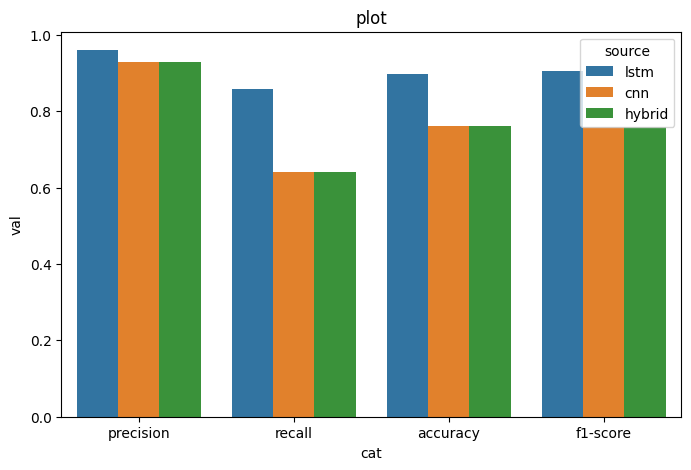

In [377]:
plt.figure(figsize=(8,5))
sns.barplot(x ='cat', y = 'val', data=df_w2v, hue='source')
plt.title("plot")

**TF-IDF**

In [ ]:
texts = df.message
labels = df.label;
type(labels)


In [386]:


# Example ndarray of strings and corresponding binary labels (0 for non-depression, 1 for depression)
texts = df.message.to_numpy()

labels = df.label.to_numpy()

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

print(texts[:10])

['lack understand small signific part caus anxieti depress feel incred lone soooo easi compar easi invalid'
 'told parent depress hard get gen x peopl understand someth control time cure walk keep mind busi'
 'depress someth speak even go also doubl edg sword love everi race even white peopl done much hate grandma legit white tf hate dislik peopl though'
 'made tortilla fill pb j depress cure olivia 1 depress 0'
 'gonna need depress med soon rainout spin equilibrium emoji pout face mother natur mean b h emoji face symbol mouth'
 'anxieti depress fight whos day'
 'wow sudden cure depress gave us world peac'
 'offici done kanyewest neptun justin timberlak timbaland got depress younger lot artist chang sound still support far'
 'wrong girl look look depress stress face babe examseason'
 'peterdutton mp shanebazzi agre emoji clap hand sign emoji clap hand sign emoji clap hand sign someon long experi clinic depress like add cours fuckingwel yell hit head wall say want dienobodi live forev w

In [ ]:
texts.shape

In [384]:

# Fit and transform the texts into TF-IDF features
tfidf_features = vectorizer.fit_transform(texts)
# df_tfidf = pd.DataFrame(
#     tfidf_features.todense(),
#     columns=tfidf_features.get_feature_names()
# )
# df_tfidf.head()

tfidf_features.get_shape()
print(tfidf_features)




  (0, 4796)	0.32885265542235037
  (0, 2108)	0.25881671364189013
  (0, 2965)	0.4784550415258618
  (0, 8501)	0.2975729767022106
  (0, 5520)	0.2392275207629309
  (0, 4667)	0.24639517459191693
  (0, 3413)	0.15389872204778754
  (0, 2610)	0.05826042795291189
  (0, 735)	0.12467402905354404
  (0, 1763)	0.18697958631467856
  (0, 6853)	0.21887973309655465
  (0, 8294)	0.2882952068152786
  (0, 8398)	0.2627063057601317
  (0, 9577)	0.2214714623558275
  (0, 5251)	0.2505789274749455
  (1, 1591)	0.27856886998174163
  (1, 5993)	0.24756783721541173
  (1, 5091)	0.23223825296421005
  (1, 9870)	0.29989134883205665
  (1, 2373)	0.21602827114170037
  (1, 9228)	0.18282862643537842
  (1, 2186)	0.2931213762311289
  (1, 8486)	0.23507264863664804
  (1, 6946)	0.1841204222105031
  (1, 3795)	0.3912160337324349
  :	:
  (8151, 9955)	0.4013619179000639
  (8151, 5531)	0.3427420803460123
  (8151, 2822)	0.4276619982337177
  (8152, 9846)	0.4929305863817176
  (8152, 7505)	0.4929305863817176
  (8152, 9405)	0.43478406501803646


In [ ]:
def predict(text, constant_filter = None):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    text = " ".join(tokens)
    text = np.array([text])
    text = vectorizer.transform(text)
    text_filter = constant_filter.transform(text)
    return model.predict(text_filter.toarray())

In [ ]:

# Split the dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(tfidf_features, labels, test_size=0.2, random_state=42)
x_train[:10]

In [ ]:
tfidf_features

In [ ]:
constant_filter = VarianceThreshold(threshold = 0.0002)
constant_filter.fit(x_train)


In [ ]:
x_train_filter = constant_filter.transform(x_train)
x_test_filter = constant_filter.transform(x_test)
x_train_filter.shape, x_test_filter.shape, x_train.shape

In [ ]:
x_test_filter

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=x_train_filter.shape[1], output_dim=128, input_length=x_train_filter.shape[1]))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
x_train_arr = x_train_filter.toarray()

In [ ]:
def get_correlation(data, threshold):
    corr_col = set()
    cormat = data.corr()
    for i in range(len(cormat.columns)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) > threshold:
                colname = cormat.columns[i]
                corr_col.add(colname)
    return corr_col
corr_features = get_correlation(x_train_filter, 0.70)

In [ ]:
x_train_uncorr = x_train_filter.drop(labels= corr_features, axis = 1)
x_test_uncorr = x_test_filter.drop(labels= corr_features, axis = 1)
x_train_uncorr = pd.DataFrame(x_train_uncorr)
x_test_uncorr = pd.DataFrame(x_test_uncorr)
x_train_uncorr.shape, x_test_uncorr.shape

In [ ]:

# Train the LSTM model
model.fit(x_train_arr, y_train, epochs=10, batch_size=1024, validation_split=0.1, verbose=1, callbacks=[callbacks])



In [ ]:
print(x_test_filter.shape, y_test.shape)

In [ ]:
# Evaluate the LSTM model
loss, accuracy = model.evaluate(x_test_filter.toarray(), y_test, batch_size=1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

In [ ]:
predict("happy, love, joy, smile", constant_filter)

In [ ]:
labels_pred = model.predict(x_test_filter.toarray())
labels_pred = np.round(labels_pred.flatten())

In [ ]:
print(classification_report(y_test, labels_pred))

In [ ]:
df.head()

In [ ]:
X = df['message']
y = df['label']
# Split into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=df['label'])

In [ ]:
y_train.value_counts()
